### Гипотеза: Если понизить коэффициент surge, то это  увеличит price-to-order конверсию (во время surge).
### Ожидаем: выше price-to-order конверсия во время surge.

In [59]:
import pandas as pd

df = pd.read_csv(r'D:\Учеба\Универ\Дз\post_abtest_data.csv')

# Преобразование столбца 'date' в формат даты
df['date'] = pd.to_datetime(df['date'])

df_surge.head(7)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
5,486559,2020-05-25,1,Control,1,0,surge,Android,NaN,NaN,Control
8,486559,2020-05-28,1,Control,1,0,surge,iOS,NaN,NaN,Control
10,486559,2020-05-31,1,Control,1,1,surge,Android,0.0,0.0,Control
17,139455,2020-05-31,1,Test,1,1,surge,Android,0.0,0.0,Test


In [61]:
# Фильтруем данные.
df_surge = df[df['surge'] == 'surge']

# Разделение на группы Control и Test
df_control = df_surge[df_surge['group'] == 'Control']
df_test = df_surge[df_surge['group'] == 'Test']

df_test.head(5)

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
17,139455,2020-05-31,1,Test,1,1,surge,Android,0.0,0.0,Test
19,139455,2020-05-28,1,Test,1,1,surge,iOS,0.0,1.0,Test
20,139455,2020-05-25,1,Test,1,1,surge,Android,0.0,1.0,Test
32,682337,2020-05-31,1,Test,1,1,surge,iOS,0.0,1.0,Test
36,682337,2020-05-30,1,Test,1,1,surge,Android,1.0,0.0,Test


In [75]:
# Убедимся, что user_id уникальны в каждой группе
control_user_ids = set(df_control['user_id'].unique())
test_user_ids = set(df_test['user_id'].unique())

# Найдем пересечения
duplicate_user_ids = control_user_ids.intersection(test_user_ids)

# Выводим результаты
print(f"Количество уникальных user_id в контрольной группе: {len(control_user_ids)}")
print(f"Количество уникальных user_id в тестовой группе: {len(test_user_ids)}")
print(f"Количество user_id, которые присутствуют и в контрольной, и в тестовой группе: {len(duplicate_user_ids)}")

if len(duplicate_user_ids) > 0:
    print(f"Повторяющиеся user_id: {duplicate_user_ids}")
else:
    print("Нет пересекающихся user_id между контрольной и тестовой группами.")

Количество уникальных user_id в контрольной группе: 8505
Количество уникальных user_id в тестовой группе: 8445
Количество user_id, которые присутствуют и в контрольной, и в тестовой группе: 0
Нет пересекающихся user_id между контрольной и тестовой группами.


In [63]:
# Подсчет количества записей в группах по дням
control_counts = df_control.groupby('date').size().reset_index(name='control_count')
test_counts = df_test.groupby('date').size().reset_index(name='test_count')

# Вывод результатов
print("Control Group Counts by Date:")
print(control_counts)

print("\nTest Group Counts by Date:")
print(test_counts)

Control Group Counts by Date:
        date  control_count
0 2020-05-25           2013
1 2020-05-26           2017
2 2020-05-27           2065
3 2020-05-28           2061
4 2020-05-29           2043
5 2020-05-30           2101
6 2020-05-31           2083

Test Group Counts by Date:
        date  test_count
0 2020-05-25        2066
1 2020-05-26        2011
2 2020-05-27        2082
3 2020-05-28        1975
4 2020-05-29        2065
5 2020-05-30        2069
6 2020-05-31        2101


### На каждый день в каждой группе достаточное и приблизительно равное кол-во наблюдений.

In [73]:
# Считаем конверсии price_seen to order_made для каждой группы.

control_price_seen_count = df_control['price_seen'].sum()
control_order_made_count = df_control['order_made'].sum()

test_price_seen_count = df_test['price_seen'].sum()
test_order_made_count = df_test['order_made'].sum()

conversion_control = control_order_made_count / control_price_seen_count if control_price_seen_count > 0 else 0
conversion_test = test_order_made_count / test_price_seen_count if test_price_seen_count > 0 else 0

print(f"Конверсия группы control: {conversion_control:.2%}")
print(f"Конверсия группы test: {conversion_test:.2%}")
print(f"Разница: {(conversion_test - conversion_control) :.2%}")

Конверсия группы control: 60.01%
Конверсия группы test: 61.81%
Разница: 1.81%


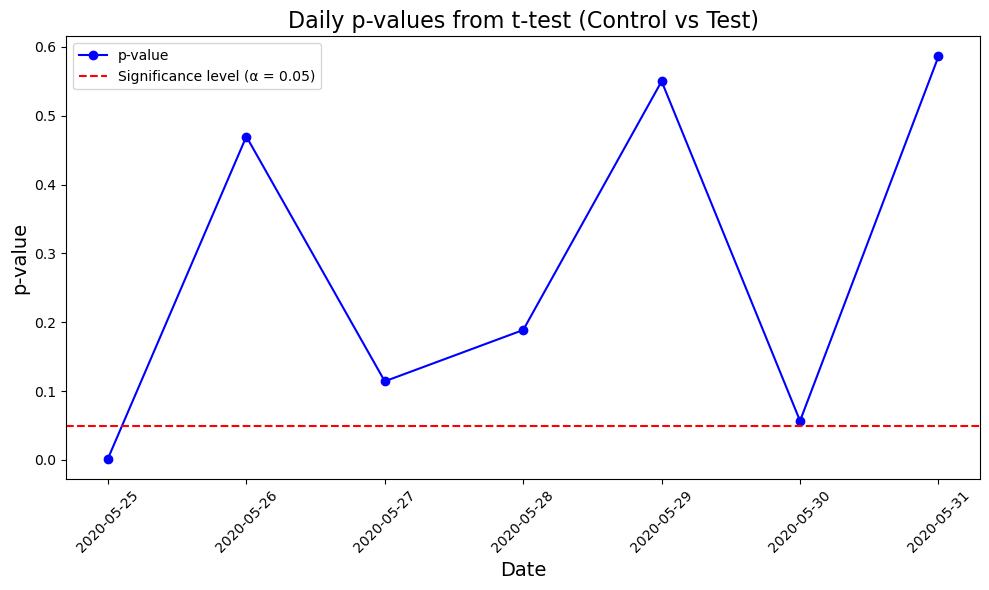

In [69]:
# Построим периодический p-value, чтобы проанализировать в динамике. 

import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

p_values = []
dates = []

# Проходим по уникальным датам
for date in df_surge['date'].unique():
    # Фильтрация данных по конкретной дате
    daily_control = df_control[df_control['date'] == date]
    daily_test = df_test[df_test['date'] == date]

    # Проверка, что есть данные в обеих группах
    if len(daily_control) > 1 and len(daily_test) > 1:
        # Извлечение значений для t-теста
        control_orders = daily_control['order_made'].values
        test_orders = daily_test['order_made'].values

        # Выполнение t-теста
        t_stat, p_val = ttest_ind(control_orders, test_orders)

        # Сохранение p-value и даты
        p_values.append(p_val)
        dates.append(date)

# Преобразуем даты и p-values в датафрейм для удобства
p_values_df = pd.DataFrame({'date': dates, 'p_value': p_values})

# Сортировка датафрейма по столбцу 'date'
p_values_df = p_values_df.sort_values(by='date')

# Визуализация p-value по дням
plt.figure(figsize=(10, 6))
plt.plot(p_values_df['date'], p_values_df['p_value'], marker='o', linestyle='-', color='b', label='p-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (α = 0.05)')  # Линия уровня значимости

# Добавляем подписи
plt.title('Daily p-values from t-test (Control vs Test)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('p-value', fontsize=14)
plt.xticks(rotation=45)
plt.legend()

# Показ графика
plt.tight_layout()
plt.show()

### p_value > a - принимаем Н0, изменения не значимы. 